<center><img alt="title" src="./assets/TFT.jpg"/></center>

# <center>Predicting the Best Strategy to Win in Teamfight Tactics</center>

**<center>Jason Dang, Nhat-Nguyen Vo, Wisely Kong</center>**

## <center>Introduction</center>

Teamfight Tactics (TFT) is an auto battler game developed by Riot Games. Auto battlers are strategy based games in which the player is given preparation time in order to assemble a team on a chess-like board (we'll just call these teams boards) with various units in order to fight an opposing player's board. These fights between boards do not receive any additional input from its players, as the units automatically move and attack until the enemy's board has no units.

Since TFT is a rather complex strategy game, there a variety of concepts to understand about the game.

In the game of TFT, there are 8 players per game. The main objective in each game is to be among the last 4 players left alive, as the game considers "Top 4" to be a moral victory. But in order to truly win a game of TFT, a player must obviously be the last player left alive. The main factors that go into a player's game are: their Health, Gold, Level, Units, Augments, and Components/Items.

- Health: Each player starts off with 100 Health. When a player loses a battle, their health is reduced based on how long the game has lasted and how many units are remaining on the board. At 0 Health, the player is defeated.
- Gold: During each preparation phase, the player is given Gold to utilize in order to make their board as strong as possible. Players can spend their Gold on either Levels or Units in order to do so.
- Level: The amount of units a player can place on their board is dependent on their current level. A player at level 3 can only place 3 units, level 4 can only place 4 units, and so on. The player naturally levels up as the game progresses but can also utilize their Gold during the preparation phase to level up faster.
- Units: During the preparation phase before facing against an opposing player's board, the player is presented a "Shop" with 5 Units in which they can utilize their Gold in order to purchase and place on their board for the next fight. The player can choose to use their Gold instead to re-roll the Shop to choose from 5 different choices. The Units in the Shop have three important aspects: Traits, Cost, and Rarity
    - Traits: Units have "Traits" that grant special effects for Unit with the Trait, but these effects can only be activated when a certain number of unique Units (with the Trait) are placed on the board at the same time. The more Units of the same trait, the stronger the effect.
    - Cost: When Units appear in the Shop, they cost a certain amount of Gold to purchase. The amount a Unit costs relates to how powerful the Unit is, where a Unit costing 1 Gold (the lowest amount) is comparatively weaker to a Unit costing 5 Gold (the highest amount). In addition, the Cost of a Unit relates to how often they would appear in a Shop, where a 1 Gold Unit will appear more often than a 5 Gold Unit.
    - Rarity: When first purchased from the Shop, Units starts at "1-Star". When 3 of the same Unit is purchased the Unit upgrades into "2-Star", in which the Unit's strength is increased. When 3 "2-Star" Units (of the same type) are made, the Unit becomes a "3-Star". The likelihood of reaching "3-Star" is more likely for lower Cost Units (1, 2, 3 Cost Units) compared to higher Cost Units (4, 5 Cost Units) due to how often lower Cost Units appear in the Shop.
- Augments: In certain intervals of the game players are presented with 3 options that provides a variety of benefits to the player, by either making certain Traits stronger or being granted multiple 5 Cost Units for free. There are 3 Tiers of Augments, rising from lowest strength to highest strength: Silver, Gold, Prismatic. When being presented with the 3 options, all options are of the same rarity for all players. Players can only have 3 Augments per game.
- Components/Items: In certain intervals of the game, players are granted materials, also known as Components, in which they can place on their Units to make them negligibly stronger. When two Components are combined (by placing both onto a unit), an Item is created based on the combined components that grants special effects for that specific Unit, making them significantly stronger. A Unit can only have a maximum combination of 3 Items/Components and cannot be interchanged once placed. Ideally, the most important Units on a player's board will always receive 3 Items.
    - There are also Items that are uncraftable via components and must be obtained through other means, these items all have affects differing from craftable items. Although these items are unobtainable through crafting, this does not necessarily mean they are better then craftable items.

More specific information on items, augments, units, etc can be found [here](https://tftactics.gg/).



<center><img alt="ExampleTFT" src="./assets/TFT_Example.png" title="TFT Concepts in Game"/></center>

<center><img alt="ExampleAugments"  src="./assets/Augments.png" title="Augment Example"/></center>

In this tutorial we will learn the various strategies and methods one could take during a TFT game in order to increase the likelihood of winning.

## <center>Data Collection</center>

In order to predict the best strategy in order to win in TFT, we must first decide where we will be retrieving our data. We decided the best source of data would come from the best players in the game, as they are considered the best for a reason: they know how to win. In TFT, the top players at a given time can be located through [this link, showing the leaderboard for the top players in North America](https://lolchess.gg/leaderboards?mode=ranked&region=na). As for the contents of the data, we arbitrarily chose to select the top 100 players and their last 75 games played. Since the leaderboard is constantly changing every few minutes, as players move up and down the leaderboard, we uploaded a compiled dataset to [Kaggle](https://www.kaggle.com/datasets/cmsc320tftproject/cmsc320-tft-challenger-dataset-set-65) to ease the replication process of this tutorial and have to have the data be consistent with what we use. But for clarity sakes, we will showcase the data scraping process.

The first step is gathering the names of those within the Top 100 rankings, based on the leaderboard website. The next step is to utilize the Riot Games API in order to extract the necessary data, that being the most recent 75 games those 100 players have played. In order to access the Riot Games API, you must [create / login](https://developer.riotgames.com/) to a Riot Games account to generate a development API key. Again, downloading the dataset from Kaggle will allow you to avoid having to deal with creating a development API key. Once the names are gathered and an API Key is obtained, the final step would be to compile and tidy the relevant data into a table.

In [227]:
# Import the necessary libraries that will be used for the tutorial
import requests
import csv
from bs4 import BeautifulSoup
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ast import literal_eval
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
# Obtain the HTML for the leaderboard website in order to selectively obtain the names of those in the Top 100.
leaderboard = requests.get("https://lolchess.gg/leaderboards?mode=ranked&region=na")
# Using the library BeautifulSoup, parse the HTML to obtain the required information easier (the names of the Top 100)
soup = BeautifulSoup(leaderboard.content, 'html.parser')

In [ ]:
# Create an array in order to hold the names
playerList = []

# Limit the HTML to show just the relevant sections (the names)
table_body=soup.find('tbody')
rows = table_body.find_all('tr')

# Iterate through the HTML and store specifically the names of the player into the array.
for row in rows:
    cols=row.find_all('td')
    cols=[x.text.strip() for x in cols]
    # Separate irrelevant text from the player's name with .partition()
    playerList.append(cols[1].partition("\n\n"))

# Need to remove the irrelevant text that resulted from the previous .partition() call
cleanList = []
for currentPlayer in playerList:
    player = (currentPlayer[2].lstrip())
    cleanList.append(player);

In [ ]:
# This is the API Key required to utilize Riot Games API. These expire 24 hours after being generated, so this will need to be updated if you want to progress with the code. 
# Again, the compiled dataset is in the Kaggle link if you want to avoid creating a Riot Games account. 
key = "RGAPI-792fade4-60a0-4bc5-968d-2cacf97fe150"
# Each player has a unique ID that is recognized by the Riot Games API. With this ID, we can now utilize the API to obtain the last 75 matches of that particular ID.
puuidList = []

# Iterate through the player's name in order to obtain their PUUID.
for player in cleanList:
    url = "https://na1.api.riotgames.com/tft/summoner/v1/summoners/by-name/" + player + "?api_key=" + key
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    jsonConvert = json.loads(str(soup))
    
    try:
        puuid = jsonConvert['puuid']
        puuidList.append(puuid)
    except KeyError:
        # Calling the API with too many commands could result in a Rate Limit Exceeded Error, which might result in losing data for that specific player.
        # If experiencing the Rate Limit Exceeded Error, wait to run the code again. 
        print("Unable to get " + player + " data")

In [ ]:
# Use a dictionary to store the last 75 matches per player.
matches = {}

for current in puuidList:
    url = "https://americas.api.riotgames.com/tft/match/v1/matches/by-puuid/" + current + "/ids?count=75&api_key=" + key
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    jsonConvert = json.loads(str(soup))
    matches[current] = jsonConvert

listToSet = []

#Take the dictionary and convert to a list. Then convert that to a set to create a unique list of matches for the dataset, to remove duplicate matches
for puuid in matches:
    currentMatchList = matches[puuid]
    for currentMatch in currentMatchList:
        listToSet.append(currentMatch)

listToSet = list(set(listToSet))

In [ ]:
# Create the dataframe for the data, that will display the relevant information from a match
df = pd.DataFrame();

# Since the Riot API limits the amount of requests you can send, you'd have to change the range of the for loop in order to extract all of the matches (i.e. change the [0:10] to a different range of values).
# This process does take a bit of time, mostly due to waiting for the ability to send more requests
# The rest of the tutorial will use the aforementioned CSV file from the Kaggle link in order to have consistent data.
for match in listToSet[0:10]:
    url = "https://americas.api.riotgames.com/tft/match/v1/matches/" + match + "?api_key=" + key
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    soup = str(soup)
    soup = soup.replace("\">\"", "")
    soup = soup.replace("</releases>", "")
    jsonConvert = json.loads(str(soup))
    data = pd.DataFrame.from_dict(jsonConvert['info']['participants'])
    # These dropped columns are irrelevant to the tutorial
    data = data.drop('companion', axis = 1)
    data = data.drop('gold_left', axis = 1)
    data = data.drop('last_round', axis = 1)
    data = data.drop('players_eliminated', axis = 1)
    data = data.drop('time_eliminated', axis = 1)
    data = data.drop('puuid', axis = 1)
    data = data.drop('total_damage_to_players', axis = 1)
    data['Match ID'] = jsonConvert['metadata']['match_id']
    df = pd.concat([df, data], axis = 0)

In [ ]:
# The dataset from the CSV, that shows the results and relevant data of all of the matches 
tutorialDataset = pd.read_csv('TFTdataset.csv')
tutorialDataset

,augments,level,placement,traits,units,Match ID
0,"['DebonairTrait', 'Distancing2', 'DebonairEmbl...",7,8,"[{'name': 'Assassin', 'num_units': 2, 'style':...","[{'character_id': 'Talon', 'items': [69, 19, 2...",NA1_4247681350
1,"['AssassinCutthroat', 'RichGetRicher', 'Divers...",9,3,"[{'name': 'Arcanist', 'num_units': 2, 'style':...","[{'character_id': 'Kassadin', 'items': [], 'na...",NA1_4247681350
2,"['EnchanterTrait', 'SunfireBoard', 'TwinshotTr...",8,2,"[{'name': 'Bruiser', 'num_units': 2, 'style': ...","[{'character_id': 'Sejuani', 'items': [], 'nam...",NA1_4247681350
3,"['CalculatedLoss', 'ExperimentalEmblem', 'Arca...",9,1,"[{'name': 'Arcanist', 'num_units': 4, 'style':...","[{'character_id': 'Kassadin', 'items': [], 'na...",NA1_4247681350
4,"['Phalanx1', 'ArcanistSpellBlade', 'Experiment...",9,4,"[{'name': 'Arcanist', 'num_units': 2, 'style':...","[{'character_id': 'RekSai', 'items': [], 'name...",NA1_4247681350
...,...,...,...,...,...,...
39995,"['Disintegrator1', 'TomeOfTraits1', 'AssassinE...",9,1,"[{'name': 'Assassin', 'num_units': 4, 'style':...","[{'character_id': 'Zilean', 'items': [], 'name...",NA1_4255593521
39996,"['SocialiteDuet', 'Disintegrator1', 'Backfoot2']",8,3,"[{'name': 'Bodyguard', 'num_units': 1, 'style'...","[{'character_id': 'Corki', 'items': [], 'name'...",NA1_4255593521
39997,"['ItemGrabBag1', 'ThrillOfTheHunt1', 'JeweledL...",8,4,"[{'name': 'Assassin', 'num_units': 4, 'style':...","[{'character_id': 'Nocturne', 'items': [], 'na...",NA1_4255593521
39998,"['Featherweights1', 'Weakspot', 'Archangel2']",8,7,"[{'name': 'Arcanist', 'num_units': 2, 'style':...","[{'character_id': 'Poppy', 'items': [], 'name'...",NA1_4255593521


Within the compiled CSV/dataset, each row represents a player. The columns are:  
- Augments: The three augments the player ended a game with
- Level: The level the player ended a game with
- Placement: The player's overall placement at the end of the game
- Traits: The active Traits the player had by the end of the game 
- Units: The Units the player had by the end of the game (with their rarities and items)   
- Match ID: The ID of the game. 

# <center>Data Management</center>

With the csv file created we can now clean it to make the dataset more readable.

As of now each row of the csv will look something like this:

<center>"augments": "['TFT6_Augment_DebonairTrait', ...]",

"level": "8",

"placement": "8",

"traits": "[{'name': 'Set6_traitname', 'num_units': 1, 'style': 0, 'tier_current': 0, 'tier_total': 4}, ...]",

"units": "[{'character_id': 'TFT6_(CharacterName))', 'itemNames': ['TFT_Item_(ItemName)', ...], 'items': [(ItemID), ...], 'name': '(CharacterName)', 'rarity': (Rarity number), 'tier': (Unit Cost))}, ...]",

"Match ID": "Match ID" </center>


Of the information available there's alot of redundant and useless headers such as "TFT6\_" and "Set6\_" or "TFT\_Item\_". For the sake of readability we shall remove them from the csv.

To do so we can create a function that finds these exact phrases in the csv and simply erases them.

In [2]:
# var filePath: str, contains the filepath that leads to the csv file
def cleanCSV(filePath):
    # open the csv file
    f = open(filePath)
    # save text in the file to a string to edit
    text = f.read()
    #  close the csv file
    f.close()

    # the next 6 lines of code deletes the specific unnecesary phrases
    # as well as an error item id that sometimes appears in collected data from our csv
    text = text.replace('TFT6_', '')
    text = text.replace('TFT6b_', '')
    text = text.replace('Set6_', '')
    text = text.replace('TFT_Item_', '')
    text = text.replace('Augment_', '')
    text = text.replace(', 10006', '')

    # open the csv file again
    f = open(filePath,'w')

    # save new clean text to the csv file
    f.write(text)

    # close the csv file
    f.close()

# run the function which will overwrite the old dataset with the cleaned dataset
cleanCSV("TFTdataset.csv")


The CSV is now cleaned of useless headers. We will now convert the csv to a JSON to make the data set easier to work with as well as give each row a unique ID.

Once again we'll make a function for this as well

In [3]:
# var csvFilePath: str, contains the filepath that leads to the csv file
# var jsonFilePath: str, place to save the JSON file
def make_json(csvFilePath, jsonFilePath):
     
    # create a dictionary called data
    data = {}
    # create a counter to number each row of the csv 
    counter = 0
    # Open the csv with a csv reader called DictReader
    with open(csvFilePath, encoding='utf-8') as csvf:
        csvReader = csv.DictReader(csvf)
         
        # Convert each row into a dictionary and add it to data
        for rows in csvReader:
             
            # save the row to the key represented by the counter
            data[counter] = rows
            # increment the counter
            counter += 1
 
    # Open a json writer, and use the json.dumps() function to convert the dictionary into a Json object
    # save the JSON object to a file using write()
    with open(jsonFilePath, 'w', encoding='utf-8') as jsonf:
        jsonf.write(json.dumps(data, indent=4))

# run the function which will create a json file version of the csv file
make_json("TFTdataset.csv", 'TFTdataset.json')

#  open the json file and save it to a variable for use later using json.load()
with open('TFTdataset.json') as json_file:
    data = json.load(json_file)

We we now convert all the item IDs into the English names of the Items to make the data easier to read, to do so
We will be needing one more thing and thats a itemDictionary or a dictionary for converting item IDs to items names.

These can be found by searching through the en_us.json file found at https://raw.communitydragon.org/latest/cdragon/tft/

You can either manually skim through the file for item codes or create a code to clean this, however for simplicity's sake the finished item dictionary is already saved to a json file and loaded into the code below.

In [4]:
with open('TFTitemDictionary.json') as json_file:
    itemDictionary = json.load(json_file)

With a JSON file and an item dictionary, we can now replace all item ID numbers with Item Names as well as remove redundant sections such as "itemName" and "name".

In [5]:

# create a list containing the all row numbers (keys) of the dataset
keys = list(data.keys())

# iterate through the list of keys
for key in keys:
    # save the units section of the row specified by key
    units = data[key]['units']

    # Units will be in the form of a list of dictionaries representing each unit in the team within a string
    # We want string to be just a list
    # To do so we will first make sure that units is a string
    
    if(units.__class__.__name__ == 'str'):
        if len(units) < 2:
            print("error line: ", key)
        # convert the string into a list of dictionaries using literal_eval()
        units = literal_eval(units)

    # For every item in every unit within the row we replace each ID with its respective name within the itemDictionary
    for char in range(len(units)):
        info = list(units[char].keys())
        # if this unit has a "itemNames" section remove it
        if 'itemNames' in info:
            units[char].pop('itemNames')

        # if this unit has a "names" section remove it
        if 'names' in info:
            units[char].pop('name')
        for item in range(len(units[char]['items'])):
            
            # Confirm that the ID is an actual Item ID by making sure its length is less or equal to 4
            # This is for the case that the item name is already there which could be the case
            if(len(str(units[char]['items'][item])) <= 4):
                units[char]['items'][item] = itemDictionary[str(units[char]['items'][item])]
    
    # update the row with the new information
    data[key]['units'] = units

# Save the dictionary to the json file
with open('TFTdataset.json', 'w') as json_file:
    json.dump(data, json_file)
    

We can now convert the json directly into a pandas dataframe for analysis.


In [66]:
# if the JSON isn't already saved to a variable in the form of a dictionary
# you will first need to open the json file which can be done with the following 2 lines of commented code 

# with open('TFTdataset.json') as json_file:
#     data = json.load(json_file)

df = pd.DataFrame.from_dict(data, orient = 'index')

# Some columns are currently occupied by arrays in the form of strings instead of just arrays
# To fix this you can use the following code that simply runs eval() on each array string and turns them into regular arrays
df["augments"] = df["augments"].apply(eval)
df["traits"] = df["traits"].apply(eval)
df["placement"] = pd.to_numeric(df["placement"])

df

,augments,level,placement,traits,units,Match ID
0,"[DebonairTrait, Distancing2, DebonairEmblem2]",7,8,"[{'name': 'Assassin', 'num_units': 2, 'style':...","[{'character_id': 'Syndra', 'items': [], 'name...",NA1_4247681350
1,"[AssassinCutthroat, RichGetRicher, Diversify3]",9,3,"[{'name': 'Arcanist', 'num_units': 2, 'style':...","[{'character_id': 'Kassadin', 'items': [], 'na...",NA1_4247681350
2,"[EnchanterTrait, SunfireBoard, TwinshotTrait2]",8,2,"[{'name': 'Bruiser', 'num_units': 2, 'style': ...","[{'character_id': 'Sejuani', 'items': [], 'nam...",NA1_4247681350
3,"[CalculatedLoss, ExperimentalEmblem, ArcanistE...",9,1,"[{'name': 'Arcanist', 'num_units': 4, 'style':...","[{'character_id': 'Kassadin', 'items': [], 'na...",NA1_4247681350
4,"[Phalanx1, ArcanistSpellBlade, ExperimentalEmb...",9,4,"[{'name': 'Arcanist', 'num_units': 2, 'style':...","[{'character_id': 'RekSai', 'items': [], 'name...",NA1_4247681350
...,...,...,...,...,...,...
39995,"[Disintegrator1, TomeOfTraits1, AssassinEmblem]",9,1,"[{'name': 'Assassin', 'num_units': 4, 'style':...","[{'character_id': 'Zilean', 'items': [], 'name...",NA1_4255593521
39996,"[SocialiteDuet, Disintegrator1, Backfoot2]",8,3,"[{'name': 'Bodyguard', 'num_units': 1, 'style'...","[{'character_id': 'Corki', 'items': [], 'name'...",NA1_4255593521
39997,"[ItemGrabBag1, ThrillOfTheHunt1, JeweledLotus]",8,4,"[{'name': 'Assassin', 'num_units': 4, 'style':...","[{'character_id': 'Nocturne', 'items': [], 'na...",NA1_4255593521
39998,"[Featherweights1, Weakspot, Archangel2]",8,7,"[{'name': 'Arcanist', 'num_units': 2, 'style':...","[{'character_id': 'Poppy', 'items': [], 'name'...",NA1_4255593521


# <center>Exploratory Data Analysis</center>


Create a function that will calculate the specific win rate for the given data. A funtion was created to achieve these tasks because it will help simplify and eliminate the need to duplicate code.

Input:
- data (DataFrame): The target dataframe for calculating the win rate for
- group (String): The group that the data should be grouped by
- aggregate_funcs (Dictionary): A dictionary that maps a specific column to a specific aggregate function

Output: Pandas DataFrame

In [85]:
def data_vs_winrate(data, group, aggregate_funcs):
    # A placement of 1 equates to a win
    data["wins"] = np.where(data["placement"] == 1, 1, 0)

    # A placement of 2,3,4 equates to a "Top 4"
    data["top_4"] = np.where((data["placement"] > 1) & (data["placement"] <= 4), 1, 0)
    
    # A placement of 5, 6, 7, or 8 equates to a loss
    data["losses"] = np.where(5 <= data["placement"], 1, 0)
    
    # Temp variable to keep track of all games, which can then be used by
    # an aggregate function to count all games
    data["games"] = 1

    # Group the data by the targeted group and aggregate the specific column
    # using specified aggregate functions (i.e sum(), count(), etc.)
    data = data.groupby([group]).aggregate(aggregate_funcs)

    # Win rate is calculated by the number of wins / total number of games
    data["winrate"] = data["wins"] / data["games"]

    data["top4_rate"] = data["top_4"] / data["games"]
    
    return data

Create a function to weigh the variables winrate.

This is needed because a simple formula like (# of wins)/(# of games) would hold bias towards variables that appeared in less games, hence we must weigh variables by taking in their # of games in comparison to the number of games that the other variables appear in.
To do this we simply add the average # of wins that all variables have to each variable and divide it by the average number of games that all variables appear in plus the variables own number of games giving us a weighted winrate.

Input:
- data (DataFrame): The target dataframe to calculate the weighted win rate for
Output: A Panda Series

In [78]:
def get_weighted_winrate(data, category):
    numer = data[category] + data[category].mean()
    denom = data['games'] + data["games"].mean()
    return numer / denom

In [257]:
with open('TFTAugmentDictionary.json') as json_file:
    augmentDictionary = json.load(json_file)

with open('TFTAugmentNamesDict.json') as json_file:
    augmentNamesDictionary = json.load(json_file)

with open('TFTTraitDictionary.json') as json_file:
    traitDictionary = json.load(json_file)


Each player ends a TFT match with a number of augments. These augments are stored as an array in the row of a specific player. To speed up the process of grouping each augment with their specific win rate, we need to separate the augments of each player into their own separate columns in the dataframe using <strong>explode()</strong>. We can then proceed with using <strong>map()</strong> to map each augment to their respective tier and in-game name.

We need to then generate the unweighted win rate for each augment. This functionality is provided by our <strong>data_vs_winrate()</strong> function using designated aggregate functions for each column of interest (wins, losses, games, tier). We can then use the unweighted win rate to generate the weighted win rate using our <strong>get_weighted_winrate()</strong> function.

To assist with plotting, we decided the index of each augment which contained the name of the column into their own column in the dataframe. To get the highest win rate at the top, we sorted the weighted win rate by descending order.

<strong>New functions used:</strong>
- df.explode(): Splits the array values into their own separate rows in the dataframe
- df[].map(): Subsitute each value in the series with another value using a dictionary
- data_vs_winrate(): Takes in a dataframe, string, and dictionary as input to generate a unweighted win rate column
- get_weighted_winrate(): Takes in dataframe as input to return a series with the win rates weighted by the number of games
- df.index(): Returns the index of a dataframe
- df.sort_values(): Sort the values in the specified column by the specified order

In [318]:
# Split the array of augments into different rows in the dataframe
augment_df = df.explode("augments")

# Each augment has a specific tier (Silver, Gold, Prismatic). We manually mapped the augment to their
# respective tier in a JSON file and turned it into a dictionary that we can use to populate the tiers
# in the dataframe.
augment_df['tier'] = augment_df['augments'].map(augmentDictionary)


# Some of the augment names labeled inside the Riot Games API is inaccurate compared to the names in the game.augment_df
# Similarly, we mapped the augment's name to the correct name and turned it into a dictionary for accuracy
augment_df['augments'] = augment_df['augments'].map(augmentNamesDictionary)

# Map specific columns to their designated aggregate function. We need the total number of
# wins, losses, games, and have each tier mapped to the correct augment.
aug_aggregate_funcs = {'wins': 'sum', 'top_4': 'sum', 'losses': 'sum', 'games': 'count', 'tier':pd.Series.mode}

# Generate the unweighted win rate for the augments with the function we previously defined.
augment_df = data_vs_winrate(augment_df, 'augments', aug_aggregate_funcs)

# Generate the weighted win rate for augments.
augment_df['weighted_winrate'] = get_weighted_winrate(augment_df, 'wins')

augment_df['weighted_top4'] = get_weighted_winrate(augment_df, 'top_4')

# Place the names for all augments in their own column to help with plotting.
augment_df['augment'] = augment_df.index

# Sort the weighted win rates in descending order to get the highest win rate at the top and the lowest
# win rate at the bottom.
augment_df = augment_df.sort_values('weighted_winrate', ascending=False)


# Display the dataframe
augment_df

,wins,top_4,losses,games,tier,winrate,top4_rate,weighted_winrate,weighted_top4,augment
augments,,,,,,,,,,
Double Trouble 2,122,180,207,509,Gold,0.239686,0.353635,0.180209,0.366725,Double Trouble 2
The Golden Egg,65,81,100,246,Prismatic,0.264228,0.329268,0.168300,0.363562,The Golden Egg
Binary Airdrop,257,553,646,1456,Gold,0.176511,0.379808,0.162526,0.379475,Binary Airdrop
Sharpshooter,87,177,177,441,Prismatic,0.197279,0.401361,0.157498,0.388629,Sharpshooter
Cybernetic Uplink 2,179,385,485,1049,Gold,0.170639,0.367016,0.155163,0.371055,Cybernetic Uplink 2
...,...,...,...,...,...,...,...,...,...,...
Blue Battery 1,172,636,927,1735,Silver,0.099135,0.366571,0.105745,0.369511,Blue Battery 1
Ascension,64,241,412,717,Silver,0.089261,0.336123,0.105469,0.354766,Ascension
Ludens Echo 2,121,499,661,1281,Gold,0.094457,0.389539,0.104120,0.386213,Ludens Echo 2


To visualize our data, we opted to use a barplot since one variable would be categorical and the other is numerical. However, since the categorical portion is quite long (length-wise), we decided that the barplot would be horizontal. With that in mind, we chose to make the x value be the weighted win rate and the y value be the augments.

To make our data more manageable, we split the data into three different plots based on the augment's tier (Silver, Gold, Prismatic) using seaborn's <strong>FacetGrid()</strong> function and mapped a barplot to each grid using the <strong>map()</strong> function. After looking at the data, we realized that the scale for the x values are too large, so we scaled it down to better fit the data in the plot.

<strong>New functions used:</strong>
- sns.FacetGrid(): Creates multiple plots based on conditonal relationships
- sns.FacetGrid.map(): Applies a plotting function to each facet's subset of the data

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


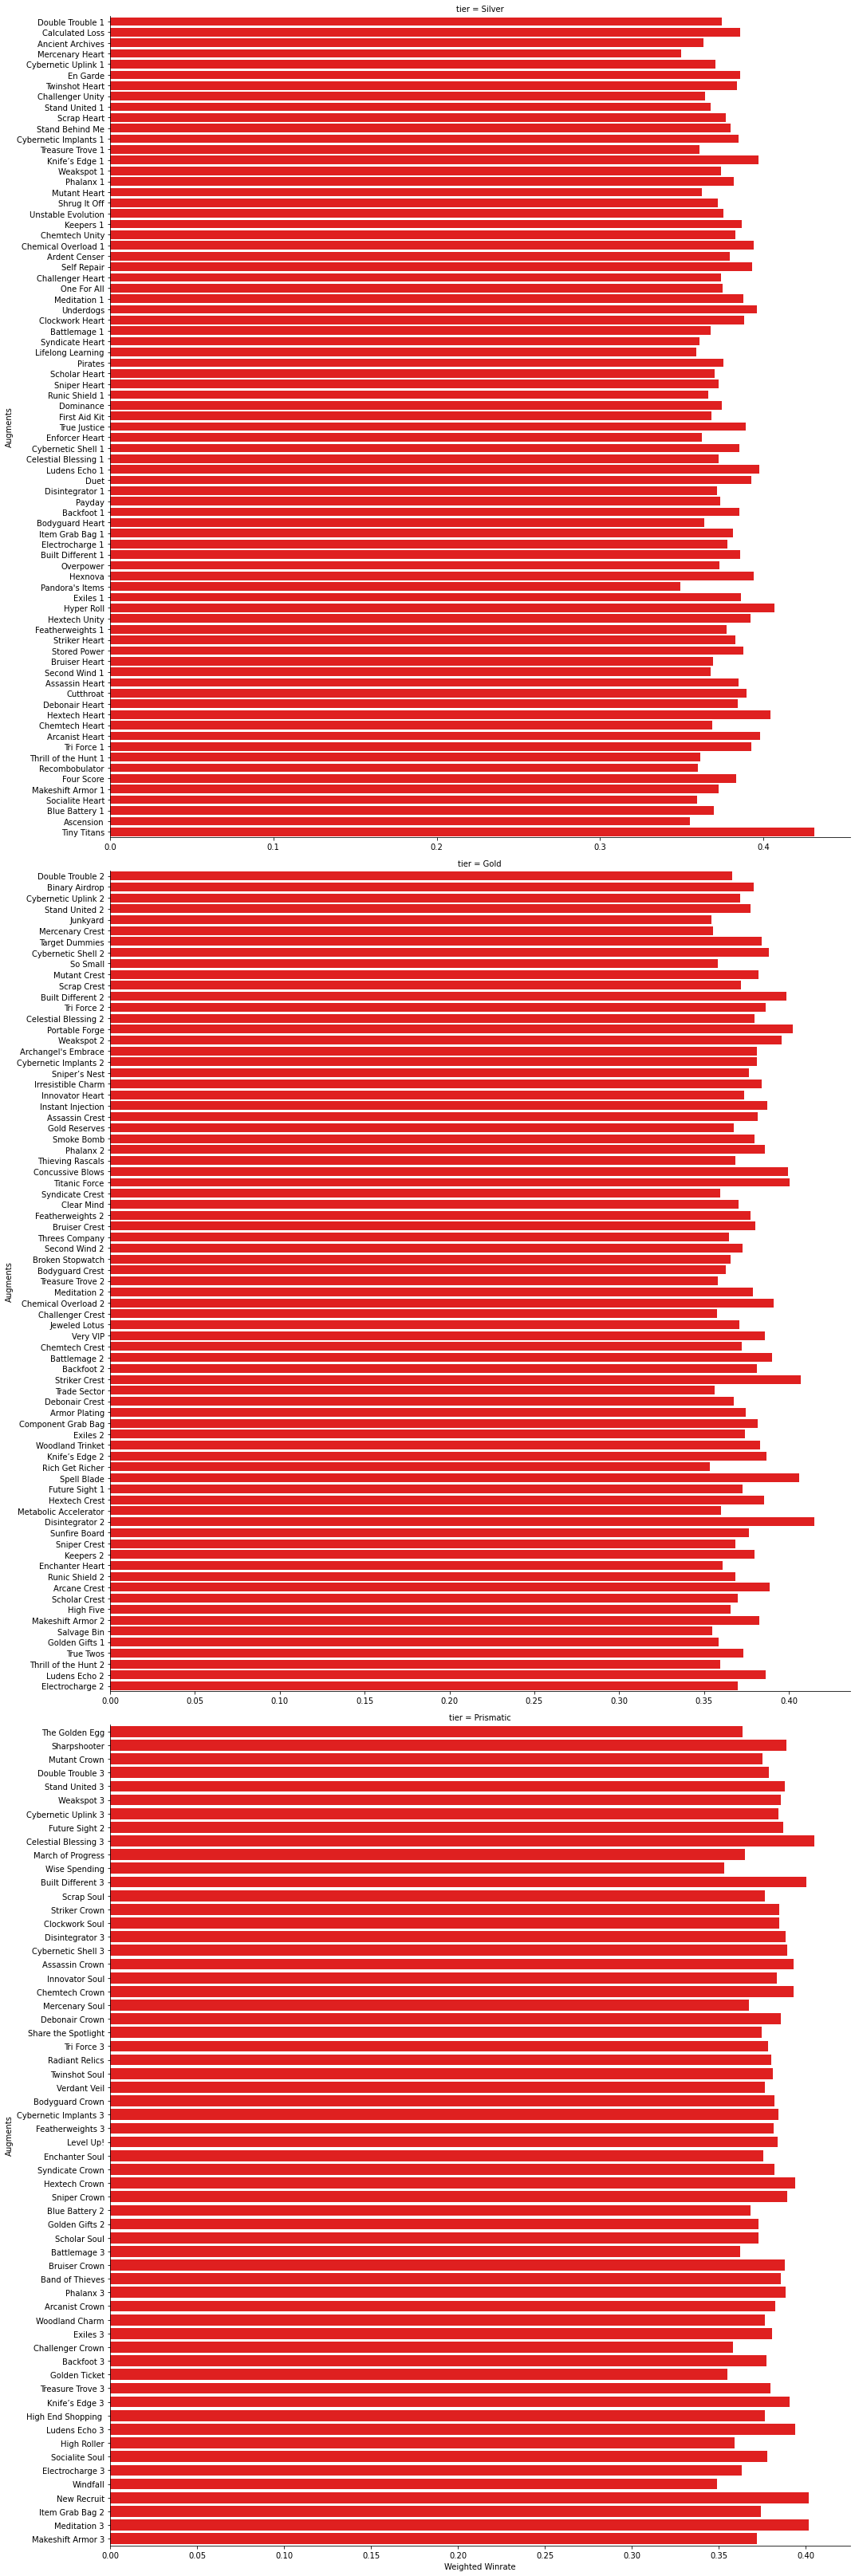

In [94]:
# Use seaborn's FacetGrid function to create separate plots grouped together by the augment's tier
g = sns.FacetGrid(augment_df, col="tier", col_order=["Silver", "Gold", "Prismatic"], 
    height=15, col_wrap=1, sharex=False, sharey=False)

# Map each plot to a barplot with the weighted win rate as the x value and the y value as the
# augments to create horizonal bar plots that are more readable
g.map(sns.barplot, 'weighted_winrate', 'augment', color='b')

# Reduce the scale of the barplot to fit the data better
g.set(xlim=[0.45, 0.55])

# Set the axis labels
g.set_axis_labels("Weighted Winrate", "Augments")

# Display the plot
plt.show()

For the traits data, we essentially performed the same actions that we performed for the augments data and utilized the same functions. However, traits consist of extraneous data that won't be needed for our visualization (num_units, style, tier_total). Additionally, some traits the same name but different tier. To ensure that all traits are unique, we concatenated the name of each trait with their current tier.

Some players ended up with no tiers at the end of the match. To account for that, we replaced them with a recognizable missing value (<strong>np.nan</strong>) and dropped the rows that contained missing traits from the dataframe. Lastly, some traits weren't activated which would skew our results so those were also dropped out of the dataframe. For the remaining traits, the API mislabeled most of them, so we manually mapped the traits with their respective in-game names.

<strong>New functions used:</strong>
- df.apply(func): Apply a function along an axis of the DataFrame
- df.dropna(subset): Drop the row that has missing values in the specified column (subset)
- df.drop(index): Drop the row with the specified index

In [87]:
# Separate the array of traits into their own rows in the dataframe
trait_df = df.explode("traits")

# Remove unncessary values such as num_units and tier_total. Create a unique trait name by concatenating
# the name of the trait with trait's current level (tier_current). If the current player doesn't have
# traits, then designate it as a missing value.
trait_df["traits"] = trait_df["traits"].apply(lambda x: (x.get('name') + str(x.get('tier_current'))) \
if type(x) is dict else np.nan)

# Drop all rows that have missing values in the traits column
trait_df = trait_df.dropna(subset=['traits'])

# Rename the traits that the API mislabeled compared to the in-game version
# Traits with parentheses and a number indicate the requirement in activating that specific trait
# For example, Innovator (7) means 7 Units with the Innovator Trait must be in the team
trait_df['traits'] = trait_df['traits'].map(traitDictionary)

# Map specific columns to their designated aggregate function. We need the total number of
# wins, losses, and games.
aggregate_funcs = {'wins': 'sum', 'top_4': 'sum', 'losses': 'sum', 'games': 'count'}

# Generate the unweighted win rate for the traits.
trait_df = data_vs_winrate(trait_df, 'traits', aggregate_funcs)

# Generate the weighted win rate for the traits.
trait_df['weighted_winrate'] = get_weighted_winrate(trait_df, 'wins')
trait_df['weighted_top4'] = get_weighted_winrate(trait_df, 'top_4')

# Only want to show activated traits
for index,row in trait_df.iterrows():
    if "0" in index:
        trait_df = trait_df.drop(index)

# Sort the weighted win rate for the traits in descending order so that the highest win rate is at
# the top of the plot.
trait_df = trait_df.sort_values('weighted_winrate', ascending=False)

# Display the dataframe.
trait_df

,wins,top_4,losses,games,winrate,top4_rate,weighted_winrate,weighted_top4
traits,,,,,,,,
Transformer (1),1724,3716,3007,8447,0.204096,0.439919,0.190015,0.429328
Mastermind (1),2182,5029,3652,10863,0.200865,0.462948,0.189935,0.449710
Glutton (1),1097,2093,2021,5211,0.210516,0.401650,0.188477,0.399661
Scrap (4),561,1166,1163,2890,0.194118,0.403460,0.170740,0.399771
Innovator (7),166,296,164,626,0.265176,0.472843,0.168175,0.410427
...,...,...,...,...,...,...,...,...
Bruiser (4),341,1148,1822,3311,0.102990,0.346723,0.121906,0.368601
Arcanist (4),153,621,1053,1827,0.083744,0.339901,0.120328,0.373053
Yordle (3),161,614,1213,1988,0.080986,0.308853,0.117884,0.358643


Unlike the augments data, the traits table will be plotted in a single bar plot since it doesn't have as many unique values as the augments data.

<strong>New functions used:</strong>
- plt.subplots(figsize): Creates a plot with the specified size
- sns.barplot(): Plots a barplot

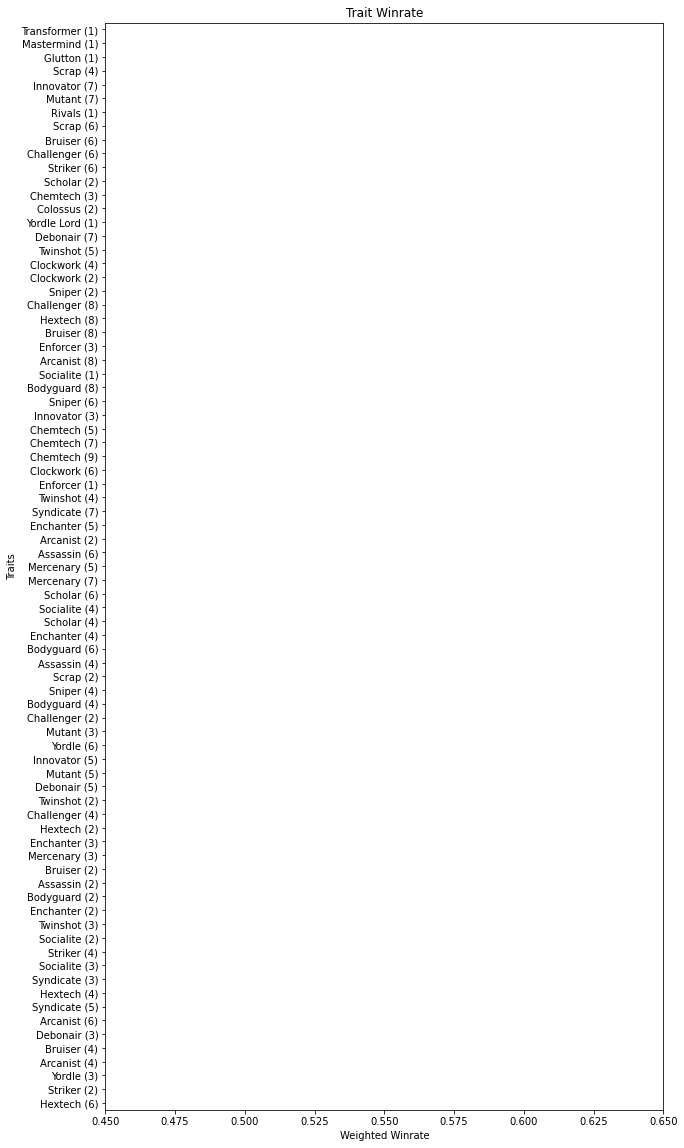

In [110]:
# Set the size of the plot.
f, ax = plt.subplots(figsize=(10, 20))

# Create the horizontal bar plot with x value being the weighted win rate and the y value being the
# trait.
sns.barplot(x="weighted_winrate", y=trait_df.index, data=trait_df, ax=ax,
            label="test", color="sienna", order = trait_df.index)

# Set the scale of the x axis to fit the data in the graph better
ax.set_xlim(0.45, 0.65)

# Set the axis labels and the title.
plt.title("Trait Winrate")
plt.xlabel("Weighted Winrate")
plt.ylabel("Traits")

# Display the plot.
plt.show()

Most of the actions performed to find the weighted win rate for each unit was done similarly to the augments data and traits data.

Each unit has a specific price designated by its cost (value of the rarity + 1). To keep track of the cost of each unit, we extracted the value from the JSON object (dictionary) and placed it in its own column (series). Each unit is represented as a JSON object, but we don't need them to be represented that way. So we extracted the names of each unit and replaced the JSON object with the unit's name (character_id).

In the final dataframe, the dataframe includes another column titled cost (the cost of each unit). Additionally, to help with plotting, we placed the index (unit names) in their own column in the dataframe.

In [89]:
# Separate the units into their own rows in the dataframe
unit_df = df.explode("units")

# Each unit has a specific cost to purchase, so extract the cost from the JSON object (Dictionary) and
# place it in its own column. The cost is based on the rarity + 1.
unit_df["cost"] = unit_df["units"].apply(lambda x: x.get('rarity') + 1 if type(x) is dict else x)

# We only want the name of the unit and not the entire JSON object, so extract the name from the
# dictionary and replace the JSON object with the unit name (character_id).
unit_df["units"] = unit_df["units"].apply(lambda x: x.get('character_id') if type(x) is dict else x)

# Map specific columns to their designated aggregate function. We need the total number of
# wins, losses, games, and the cost of each unit.
unit_aggregate_functions = {'wins': 'sum', 'top_4': 'sum', 'losses': 'sum', 'games': 'count', 'cost': 'max'}

# Generate the unweighted win rate for each unit.
unit_df = data_vs_winrate(unit_df, 'units', unit_aggregate_functions)

# Generate the weighted win rate for each unit.
unit_df['weighted_winrate'] = get_weighted_winrate(unit_df, 'wins')
unit_df['weighted_top4'] = get_weighted_winrate(unit_df, 'top_4')

# Place the unit names in their own column to help with plotting.
unit_df['unit'] = unit_df.index

# Sort the weighted win rate for the units in descending order so the highest win rate is at the top.
unit_df = unit_df.sort_values('weighted_winrate', ascending=False)

# Display the unit.
unit_df

,wins,top_4,losses,games,cost,winrate,top4_rate,weighted_winrate,weighted_top4,unit
units,,,,,,,,,,
Jinx,1780,3669,2960,8409,5.0,0.211678,0.436318,0.181966,0.416650,Jinx
Silco,2203,5090,3674,10967,5.0,0.200875,0.464120,0.179358,0.438465,Silco
Jayce,1764,3771,3047,8582,5.0,0.205546,0.439408,0.178549,0.418803,Jayce
TahmKench,1123,2139,2055,5317,5.0,0.211209,0.402295,0.173091,0.393917,TahmKench
Kaisa,958,1984,1651,4593,5.0,0.208578,0.431962,0.169087,0.407056,Kaisa
Viktor,1289,3046,2516,6851,5.0,0.188148,0.444607,0.164911,0.418798,Viktor
Galio,434,948,662,2044,5.0,0.212329,0.463796,0.156451,0.407271,Galio
Zeri,816,2011,1946,4773,5.0,0.170962,0.421328,0.151995,0.402470,Zeri
Orianna,1753,4671,5253,11677,4.0,0.150124,0.400017,0.145382,0.395487,Orianna


Similar to the augments data, we need to make the data more manageable and ensure that the data is reasonable (it makes sense). So we split the data into separate groups based on the cost of the unit. Just like the augments data, it's easier to compare two different variables when they are grouped together by a commonality.

We also mapped each cost with a color to help with the visualization of the data.

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


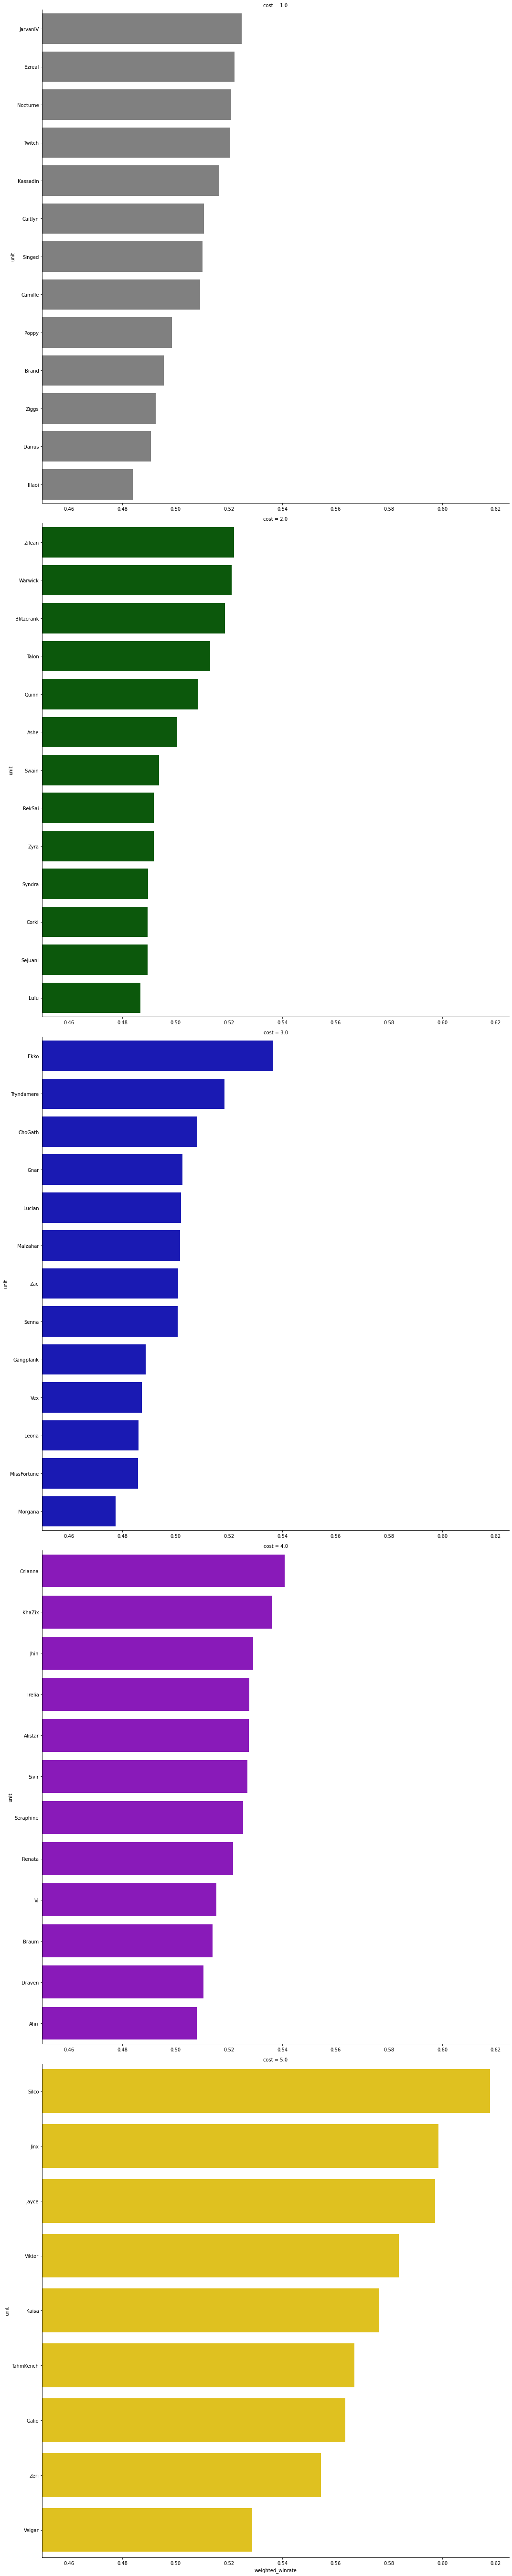

In [15]:
# Designate specific colors to each cost
palette_cost = {5:"gold", 4:"darkviolet", 3:"mediumblue",2:"darkgreen",1:"grey"}

# Create separate plots for each cost using seaborn's FacetGrid function
g = sns.FacetGrid(unit_df, col="cost",  height=15, col_wrap=1, sharex=False, sharey=False, 
hue = 'cost', palette=palette_cost)

# Reduce the scale for the x values so that the data fits better in the plot
g.set(xlim=[0.45, 0.625])

# Map each plot to a barplot with the weighted win rate as the x value and the y value as the
# augments to create horizonal bar plots that are more readable
g.map(sns.barplot, "weighted_winrate", "unit")

# Display the plot
plt.show()

Similar to the previous dataframes, we used similar functions and performed similar actions to generate the weighted win rate for each item.

However, we needed to separate the items into two different groups (components and uncraftables). This is because components are essentially useless since they are used to create craftables. Craftables and uncraftables are the ones that actually have an effect on our data since they provide benefits to the player that helps the player achieve a higher placement.

In the case of items, they are stored in each unit as an array because each unit are given a specified number of items. But we will only be constructing our data with units that have three items. This is because units with three items are considered more significant than units with less than 3 items. Units with less than 3 items are considered filler units to hold items which doesn't have an effect on the win rate.

The types of each item (Components, Uncraftable, Craftable) are in their own separate column (series).

<strong>New functions used:</strong>
- append(): Appends a value to an array (list)

In [88]:
# Separate the items into components and uncraftable items
components = ["B.F. Sword", "Chain Vest", "Giant’s Belt", "Needlessly Large Rod", "Negatron Cloak", "Recurve Bow", "Sparring Gloves", "Spatula", "Tear of the Goddess"]
uncraftable = ["Anima Visage", "Death's Defiance", "Eternal Winter", "Infinity Force", "Manazane", "Obsidian Cleaver", "Randuin's Sanctum", "Rocket-Propelled Fist", "Gold Collector", "Zhonya's Paradox", "Bodyguard Emblem", "Clockwork Emblem", "Mercenary Emblem", "Socialite Emblem", "Enforcer Emblem", "Scrap Emblem", "Bruiser Emblem", "Innovator Emblem", "Sniper Emblem", "Scholar Emblem", "Luminous Deathblade", "Demonslayer", "Hextech Lifeblade", "Spear of Hirana", "Brink of Dawn", "Blessed Bloodthirster", "Zeke's Harmony", "Zenith Edge", "Rapid Lightcannon", "Guinsoo's Reckoning", "Statikk's Favor", "Titan's Vow", "Runaan's Tempest", "Zz'Rots Invitation", "Eternal Whisper", "Rabadon's Ascended Deathcap", "Urf-Angel's Staff", "Locket of Targon Prime", "Covalent Spark", "More More-ellonomicon", "Glamorous Gauntlet", "Blue Blessing", "Frozen Heart Of Gold", "Chalice of Charity", "Radiant Redemption", "Fist of Fairness", "Rosethorn Vest", "Dvarapala Stoneplate", "Sunlight Cape", "Shroud of Reverence", "Dragon's Will", "Mistral", "Quickestsilver", "Warmog's Pride", "Banshee's Silence", "Rascal's Gloves" ]
types = []

# Separate the unit array into separate rows for each unit since each unit has an array of items
item_df = df.explode("units")

# Extract the array of items from each unit
item_df["items"] = item_df["units"].apply(lambda x: x.get('items') if type(x) is dict and \
len(x.get('items')) == 3 else np.nan)

# Drop the missing values in the items column
item_df = item_df.dropna(subset=['items'])

# Separate the item array into separate rows in the dataframe
item_df = item_df.explode('items')

# Generate the unweighted win rate for each item
item_df = data_vs_winrate(item_df, 'items', aggregate_funcs)

# Generate the weighted win rate for each item
item_df['weighted_winrate'] = get_weighted_winrate(item_df, 'wins')
item_df['weighted_top4'] = get_weighted_winrate(item_df, 'top_4')

# Only want to see full Items, not Components
for index,row in item_df.iterrows():
    if index in components:
        item_df = item_df.drop(index)
    else:
        # If it is a full Item, check to see if the player can craft it themselves.
        if index in uncraftable:
            types.append("Uncraftable")
        else:
            types.append("Craftable")

# Put the types of each item into their own column    
item_df['type'] = types

# To help with plotting, the index (item names) are placed in their own column
item_df["itemName"] = item_df.index

# Sort the weighted win rate for each item in descending order to have the highest win rate at the top
item_df = item_df.sort_values('weighted_winrate', ascending=False)

# Display the plot
item_df 


,wins,top_4,losses,games,winrate,top4_rate,weighted_winrate,weighted_top4,type,itemName
items,,,,,,,,,,
Zeke's Herald,1138,2706,1754,5598,0.203287,0.483387,0.192526,0.469256,Craftable,Zeke's Herald
Edge of Night,926,1954,1619,4499,0.205824,0.434319,0.192464,0.434175,Craftable,Edge of Night
Mutant Emblem,225,400,294,919,0.244831,0.435256,0.188669,0.434285,Craftable,Mutant Emblem
Shroud of Stillness,517,1122,849,2488,0.207797,0.450965,0.187817,0.442880,Craftable,Shroud of Stillness
Banshee's Claw,575,1356,889,2820,0.203901,0.480851,0.186956,0.460078,Craftable,Banshee's Claw
...,...,...,...,...,...,...,...,...,...,...
Thief's Gloves,946,2634,2778,6358,0.148789,0.414281,0.153161,0.419383,Craftable,Thief's Gloves
Hextech Gunblade,1243,3383,3676,8302,0.149723,0.407492,0.153091,0.413094,Craftable,Hextech Gunblade
Blue Buff,1346,3740,4197,9283,0.144996,0.402887,0.148995,0.408906,Craftable,Blue Buff


To help with plotting each item in two separate groups (Craftable and Uncraftable), the index (item names) need to be placed into a separate column (series). For better visualization, each item is mapped to a certain color.

The data is then plotted as separate bar plots grouped by the item type.

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


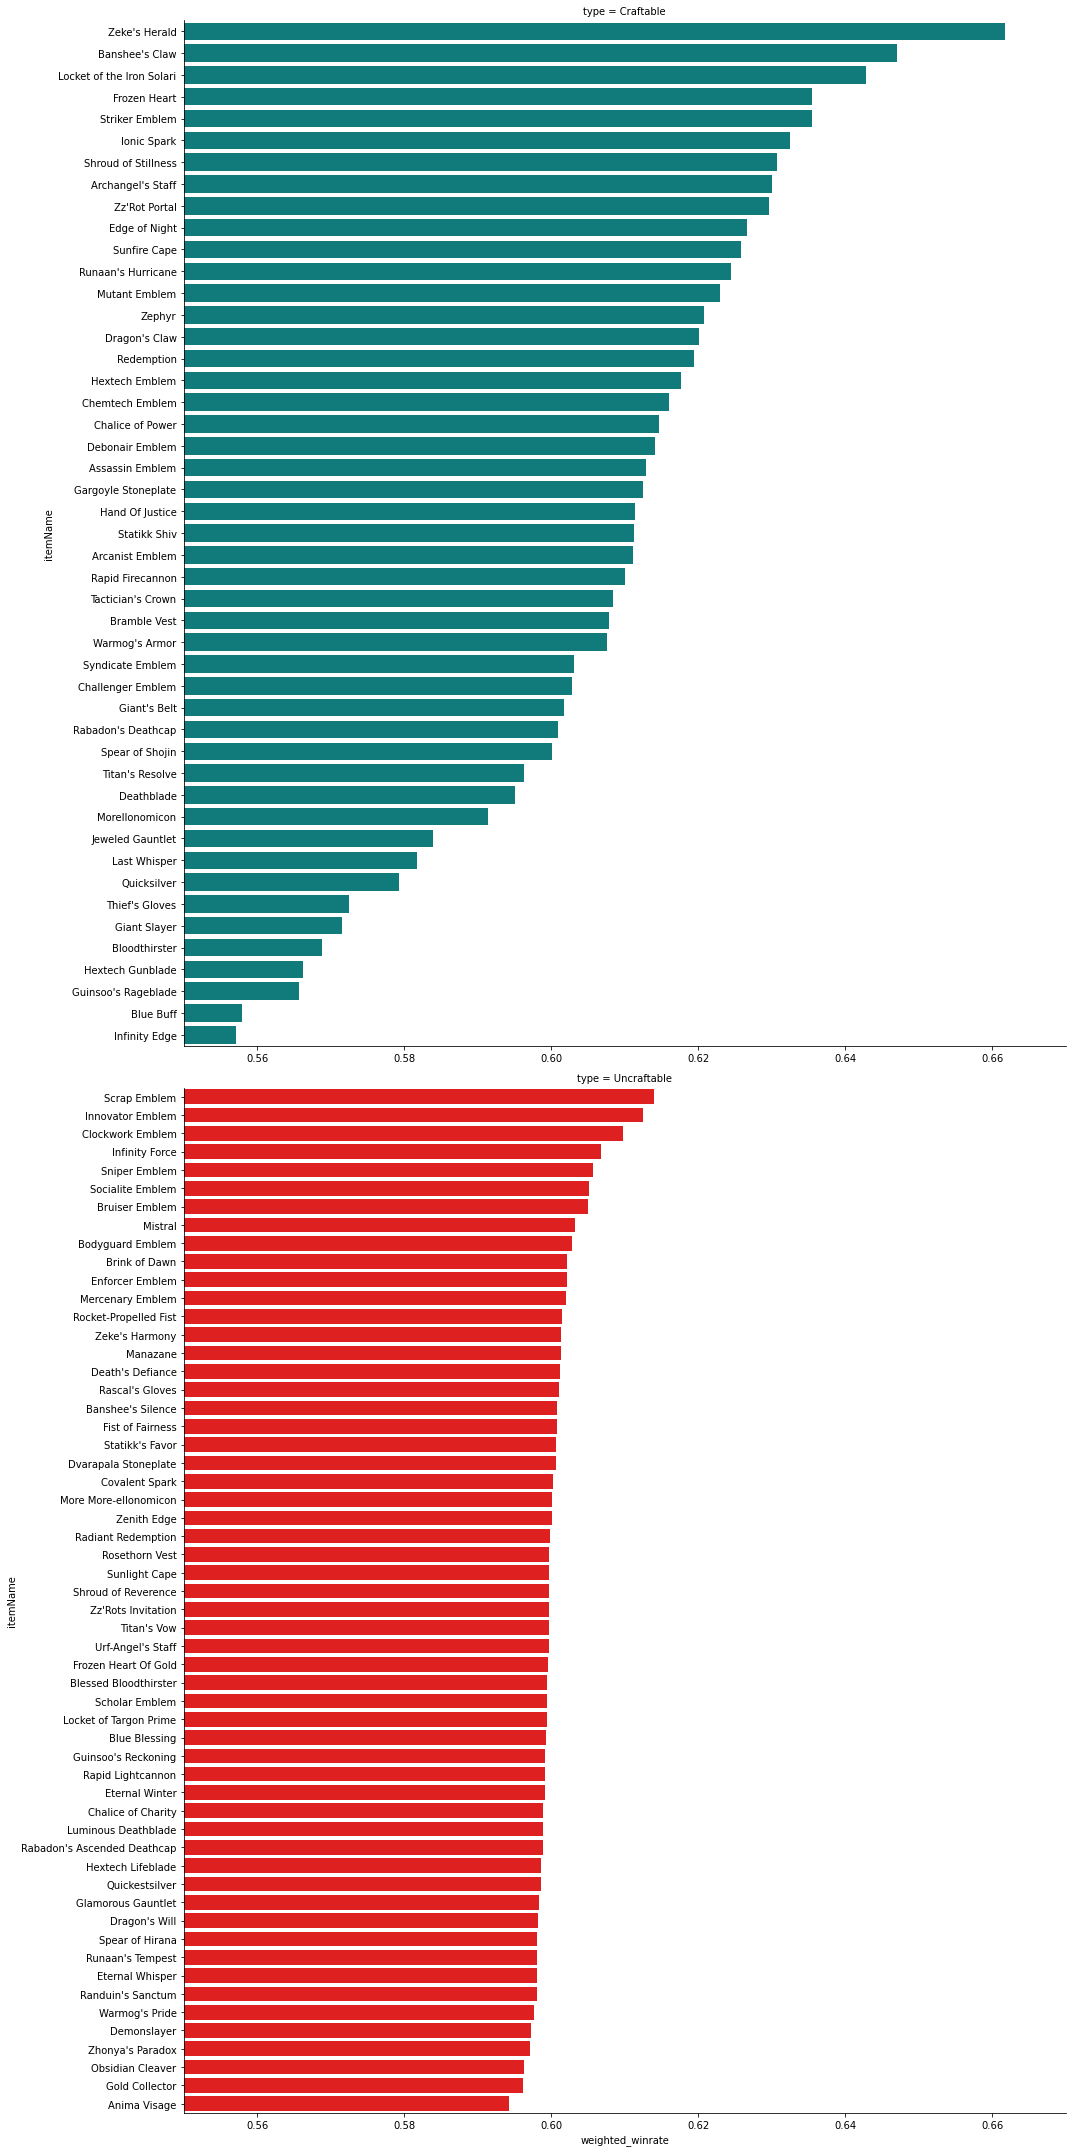

In [17]:
# Designate specific colors to whether the item is craftable or uncraftable
palette_type = {"Uncraftable":"red", "Craftable":"darkcyan"}

# Create separate plots for craftable and uncraftable items using seaborn's FacetGrid function
f = sns.FacetGrid(item_df, col="type",  height=15, col_wrap=1, sharex=False, sharey=False, 
hue = 'type', palette=palette_type)

# Reduce the scale for the x values so that the data fits better in the plot
f.set(xlim=[0.55, 0.67])

# Map each plot to a barplot with the weighted win rate as the x value and the y value as the
# item to create horizonal bar plots that are more readable
f.map(sns.barplot, "weighted_winrate", "itemName")

# Display the plot
plt.show()


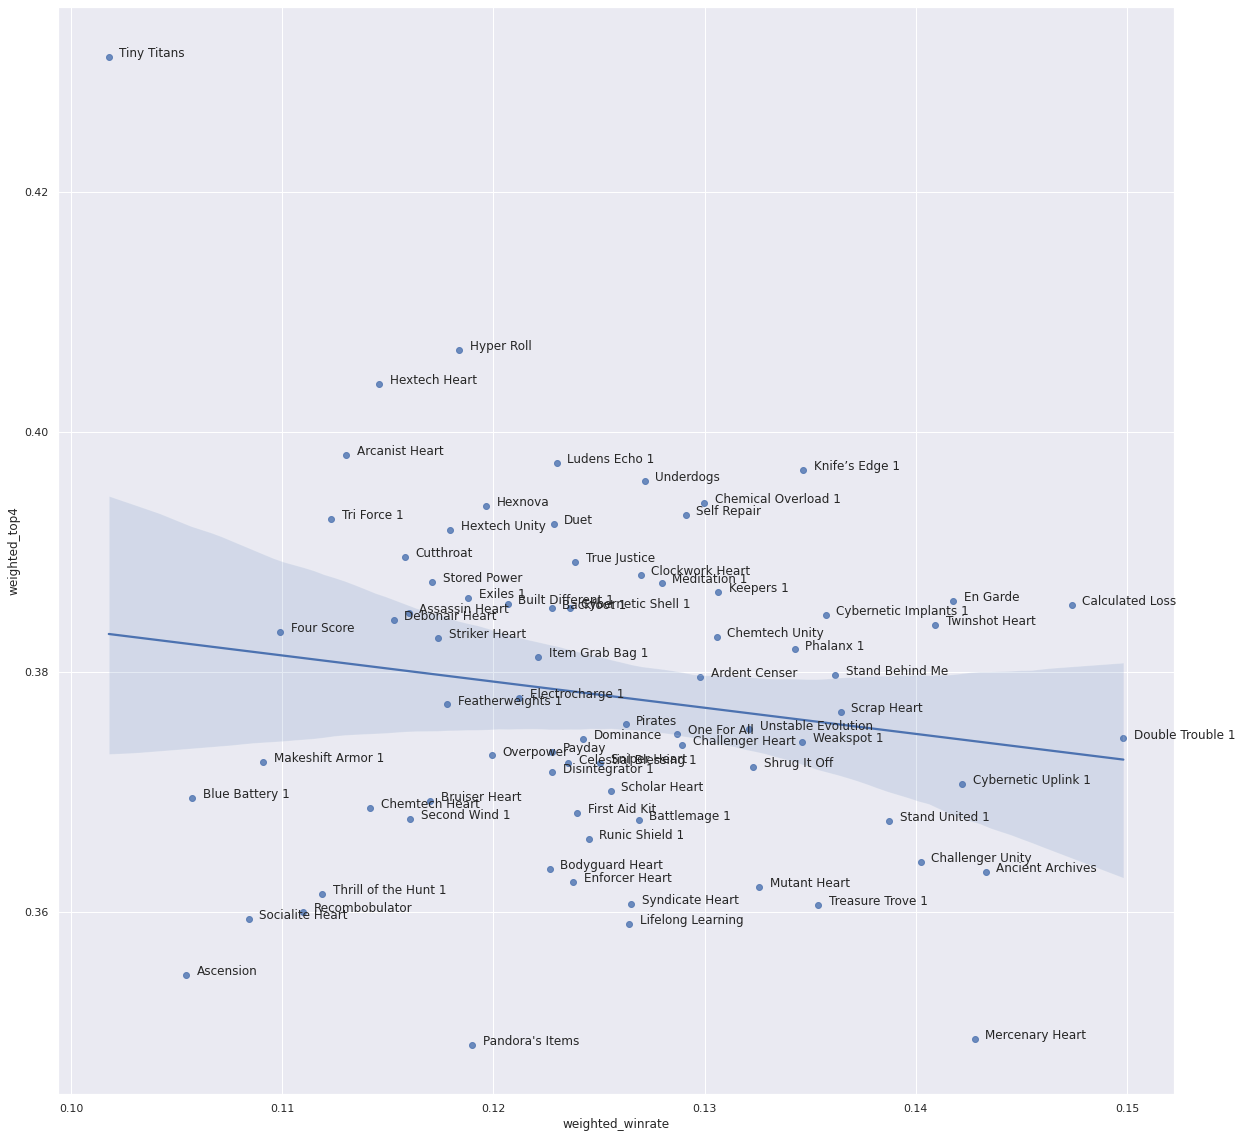

In [247]:

f, ax = plt.subplots(figsize=(20, 20))

augment_separate = augment_df.groupby('tier')
silver_augments = augment_separate.get_group("Silver")
ax = sns.regplot(data = silver_augments, x="weighted_winrate", y = "weighted_top4")

for index, row in silver_augments.iterrows():
    plt.annotate(row['augment'], (row['weighted_winrate'] + 0.0005, row['weighted_top4']))

# annotate_points(x="weighted_top4", y = "weighted_winrate", t='augment', data=silver_augments, xticks=np.arange(0.32, 0.44, 0.01))
# ax.legend(ncol=7, loc=9, bbox_to_anchor=(0.5, -0.1))

plt.show()


In [274]:
from sklearn.preprocessing import LabelEncoder
def dummyEncode(df):
    # Filters through dataframe and recognizes categorical variables
    columnsToEncode = list(df.select_dtypes(include=['category','object']))
    le = LabelEncoder()
    for feature in columnsToEncode:
        try:
            df[feature] = le.fit_transform(df[feature])
        except:
            print('Error encoding '+feature)
    return df

In [127]:
test3 = df.copy()
numOfComponents = []
for index, row in test3.iterrows():
    count = 0
    for unit in row['units']:
        for item in unit['items']:
            if item in components:
                count += 1
            else:
                count += 2
    numOfComponents.append(count)
test3['numOfComponents'] = numOfComponents

In [159]:
test3

,augments,level,placement,traits,units,Match ID,numOfComponents
0,"[DebonairTrait, Distancing2, DebonairEmblem2]",7,8,"[{'name': 'Assassin', 'num_units': 2, 'style':...","[{'character_id': 'Syndra', 'items': [], 'name...",NA1_4247681350,15
1,"[AssassinCutthroat, RichGetRicher, Diversify3]",9,3,"[{'name': 'Arcanist', 'num_units': 2, 'style':...","[{'character_id': 'Kassadin', 'items': [], 'na...",NA1_4247681350,23
2,"[EnchanterTrait, SunfireBoard, TwinshotTrait2]",8,2,"[{'name': 'Bruiser', 'num_units': 2, 'style': ...","[{'character_id': 'Sejuani', 'items': [], 'nam...",NA1_4247681350,20
3,"[CalculatedLoss, ExperimentalEmblem, ArcanistE...",9,1,"[{'name': 'Arcanist', 'num_units': 4, 'style':...","[{'character_id': 'Kassadin', 'items': [], 'na...",NA1_4247681350,22
4,"[Phalanx1, ArcanistSpellBlade, ExperimentalEmb...",9,4,"[{'name': 'Arcanist', 'num_units': 2, 'style':...","[{'character_id': 'RekSai', 'items': [], 'name...",NA1_4247681350,22
...,...,...,...,...,...,...,...
39995,"[Disintegrator1, TomeOfTraits1, AssassinEmblem]",9,1,"[{'name': 'Assassin', 'num_units': 4, 'style':...","[{'character_id': 'Zilean', 'items': [], 'name...",NA1_4255593521,24
39996,"[SocialiteDuet, Disintegrator1, Backfoot2]",8,3,"[{'name': 'Bodyguard', 'num_units': 1, 'style'...","[{'character_id': 'Corki', 'items': [], 'name'...",NA1_4255593521,20
39997,"[ItemGrabBag1, ThrillOfTheHunt1, JeweledLotus]",8,4,"[{'name': 'Assassin', 'num_units': 4, 'style':...","[{'character_id': 'Nocturne', 'items': [], 'na...",NA1_4255593521,22
39998,"[Featherweights1, Weakspot, Archangel2]",8,7,"[{'name': 'Arcanist', 'num_units': 2, 'style':...","[{'character_id': 'Poppy', 'items': [], 'name'...",NA1_4255593521,21


<AxesSubplot:xlabel='placement', ylabel='numOfComponents'>

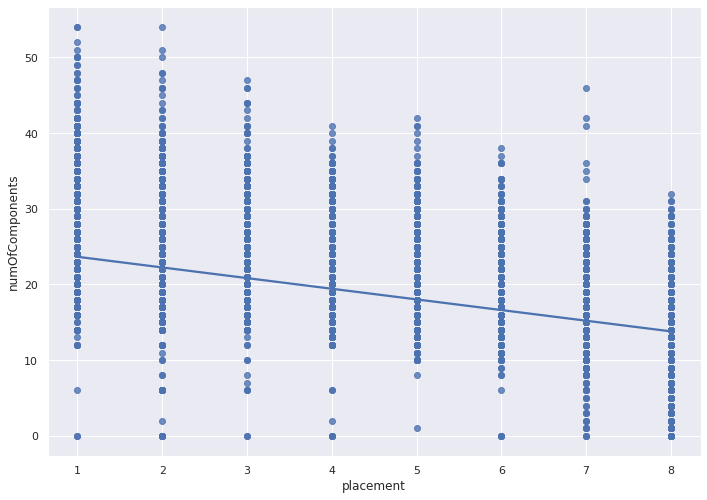

In [202]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.regplot(data=test3, x="placement", y="numOfComponents")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a232a31a-1f79-495a-bb02-174ffb8d4629' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>